<a href="https://colab.research.google.com/github/sheharyarakhtar/MediumArticles/blob/main/Recurrent_Neural_Network_with_NumPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Iteration: 0 | Mean Loss: 0.6676370145973927
Iteration: 200 | Mean Loss: 0.4401007008326901
Iteration: 400 | Mean Loss: 0.3566669381808497
Iteration: 600 | Mean Loss: 0.2771252162056014
Iteration: 800 | Mean Loss: 0.21876586270197312
Iteration: 1000 | Mean Loss: 0.18010511518295286
Iteration: 1200 | Mean Loss: 0.15338171894689176
Iteration: 1400 | Mean Loss: 0.13387417052764317
Iteration: 1600 | Mean Loss: 0.11897458396522224
Iteration: 1800 | Mean Loss: 0.10719381960406926
Iteration: 2000 | Mean Loss: 0.09762791650576469
Iteration: 2200 | Mean Loss: 0.08969553444004325
Iteration: 2400 | Mean Loss: 0.08300468334888843
Iteration: 2600 | Mean Loss: 0.07728077418734111
Iteration: 2800 | Mean Loss: 0.07232537669746607
Iteration: 3000 | Mean Loss: 0.06799133794111063
Iteration: 3200 | Mean Loss: 0.06416711721054447
Iteration: 3400 | Mean Loss: 0.06076656462331644
Iteration: 3600 | Mean Loss: 0.05772204638490888
Iteration: 3800 | Mean Loss: 0.05497969885724158
Iteration: 4000 | Mean Loss: 0.

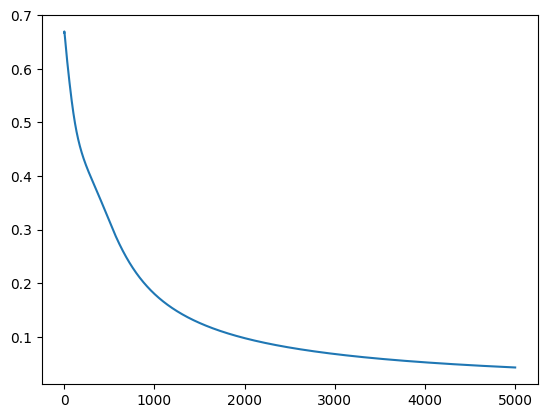

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class RNN():
    def __init__(self, inputs, outputs, h_size, d):
        """
        Here we initilize 4 main components
        W_input: The weight matrix that is to be multiplied with our input embeddings
        W_recurrent: The weight matrix that will be multiplied with our hidden state
        hidden: The initial value of the hidden state (we will set this as an array of zeros)
        Embeddings: These are 3-dimensional embeddings generated for each of the input values

        Observational variables
        The variables (input_emb_list, output_emb_list) contain the embedded vectors for each input and output value respectively.
        The variables (losses, final_loss, mean_losses, predictions) are observatory variables to see what is happening at each step of training
        """
        np.random.seed(42)
        self.W_input = np.random.uniform(size=(h_size, d), low=-1/np.sqrt(h_size), high=1/np.sqrt(h_size))
        self.W_recurrent = np.random.uniform(size=(h_size, h_size), low=-1/np.sqrt(h_size), high=1/np.sqrt(h_size))
        self.W_output = np.random.uniform(size=(d, h_size), low=-1/np.sqrt(h_size), high=1/np.sqrt(h_size))
        self.output_biases = np.zeros(d)

        self.hidden = np.zeros(h_size)
        self.hidden_states = [self.hidden]
        self.hidden_bias = np.zeros(h_size)

        self.inputs = inputs
        self.outputs = outputs
        self.input_emb_list = self.createEmbeddings(inputs)
        self.output_emb_list = self.createEmbeddings(outputs)
        self.losses = []
        self.final_loss = 0
        self.mean_losses = []
        self.predictions = []

    def activation_function(self, x):
        """
          Here we are using a tanh activation function but a ReLU can also be used
        """
        return np.tanh(x)

    def createEmbeddings(self, vec):
        """
        This creates a 3D embedding for binary values i.e. 1 is converted to 1,0,0 and 0 is converted to 0,0,1
        """
        input_vectors = []
        for i in vec:
            if i == 1:
                input_vectors.append([1, 0])
            else:
                input_vectors.append([0, 1])
        return input_vectors

    def forwardPass(self):
        """
        This is a single forward pass through the RNN.
        After initializing the model, we can run model.forward() to see what's the initial loss of the model
        """
        for i in range(len(self.input_emb_list)):
            input_emb = self.input_emb_list[i]
            linear_transform = np.dot(self.W_input, input_emb) + np.dot(self.W_recurrent, self.hidden) + self.hidden_bias
            self.updateValues(linear_transform, i)
        self.final_loss = np.mean(self.losses)
        self.mean_losses.append(self.final_loss)

    def softmax(self, x):
        """
        This is a custom softmax function that is implemented to avoid the problems that
        occur due to the variable memory limitations of python
        """
        f = np.exp(x - np.max(x))
        return f / f.sum(axis=0)

    def updateValues(self, linear_transform, output_number):
        """
        This function is written to update the intermediate variables during a forward pass.
        This is not the same as backward propagation and does not update the weights or biases
        in any way
        """
        self.hidden = self.activation_function(linear_transform)
        self.hidden_states.append(self.hidden)
        predicted_output = np.dot(self.hidden, self.W_output.T) + self.output_biases
        prediction = self.softmax(predicted_output)
        self.predictions.append(prediction)
        self.lossFunction(prediction, self.output_emb_list[output_number])

    def lossFunction(self, prediction, output):
        """The loss function used here is the cross_entropy_loss"""
        self.losses.append(-np.sum(output * np.log(prediction)))

    def backwardPass(self, learning_rate):
        """
        This function implements the backpropagation through time (BPTT) algorithm to update
        the weights and biases of the RNN.
        """
        dW_input = np.zeros_like(self.W_input)
        dW_output = np.zeros_like(self.W_output)
        dW_recurrent = np.zeros_like(self.W_recurrent)
        d_hidden_bias = np.zeros_like(self.hidden_bias)
        d_output_biases = np.zeros_like(self.output_biases)
        d_hidden_state = np.zeros_like(self.hidden)

        self.softmax_derivatives = np.array(self.predictions) - np.array(self.output_emb_list)
        for t in reversed(range(len(self.hidden_states))):
            d_output_biases += self.softmax_derivatives[t]
            # print(f"AT time {t}, softmax_derivative is {softmax_derivatives[t]}")
            dW_output += np.outer(self.softmax_derivatives[t], self.hidden_states[t])

            d_hidden_state = self.W_output.T.dot(self.softmax_derivatives[t]) + self.W_recurrent.T.dot(d_hidden_state)
            d_hidden_state_raw = (1 - self.hidden_states[t] ** 2) * d_hidden_state

            if t > 0:
                dW_recurrent += np.outer(d_hidden_state_raw, self.hidden_states[t - 1])
            else:
                dW_recurrent += np.outer(d_hidden_state_raw, np.zeros_like(self.hidden_states[t]))

            d_hidden_bias += d_hidden_state_raw
            dW_input += np.outer(d_hidden_state_raw, self.input_emb_list[t])

        # Update weights and biases
        self.W_input -= learning_rate * dW_input
        self.W_output -= learning_rate * dW_output
        self.W_recurrent -= learning_rate * dW_recurrent
        self.hidden_bias -= learning_rate * d_hidden_bias
        self.output_biases -= learning_rate * d_output_biases

    def UndoEmbeddings(self, embeddings):
        unembedded = []
        for i in embeddings:
            if i == [1, 0]:
                unembedded.append(1)
            elif i == [0, 1]:
                unembedded.append(0)
            else:
                unembedded.append(-1)
        return unembedded

    def train(self, learning_rate, num_iterations):
        """
        Train the RNN model using backpropagation through time (BPTT).
        """
        for iter in range(num_iterations):
            self.predictions = []
            self.hidden_states = []
            self.forwardPass()
            self.hidden_states = self.hidden_states[:-1]
            self.backwardPass(learning_rate)
            if not iter % 200:
              print(f"Iteration: {iter} | Mean Loss: {self.mean_losses[-1]}")

    def predict(self, input_seq):
        """
        Predict the output sequence for the given input sequence.
        """
        num_seq = len(input_seq)
        pred_hidden = np.zeros(h_size)
        input_embeddings = self.createEmbeddings(input_seq)
        embedded_predictions = []
        self.hidden = np.zeros_like(self.hidden)
        for timestep in range(num_seq):
            self.hidden = self.activation_function(np.dot(self.W_input, [1,0]) + np.dot(self.W_recurrent, self.hidden) + self.hidden_bias)
            output = np.dot(self.W_output, hidden)+self.output_biases
            print(output)
            soft = self.softmax(output).round()
            embedded_predictions.append(soft)
        return embedded_predictions




inputs = [1, 0, 1, 1]
outputs = [0, 0, 1, 0]
h_size = 3
d = 2
model = RNN(inputs, outputs, h_size, d)
model.train(learning_rate=0.01, num_iterations=5000)
plt.plot(model.mean_losses)

True
